In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
np.random.seed(0)
torch.manual_seed(0)

In [27]:
device = torch.device("cpu")

In [28]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                transforms.Grayscale(1)
                               ])

In [29]:
covid_dataset=datasets.ImageFolder(r'C:\Users\user\Desktop\root_dir', transform=transform)

In [30]:
covid_dataset.class_to_idx

{'CT_COVID': 0, 'CT_NonCOVID': 1}

In [31]:
idx2class = {v: k for k, v in covid_dataset.class_to_idx.items()}

Text(0.5, 1.0, 'Entire Dataset (before train/val/test split)')

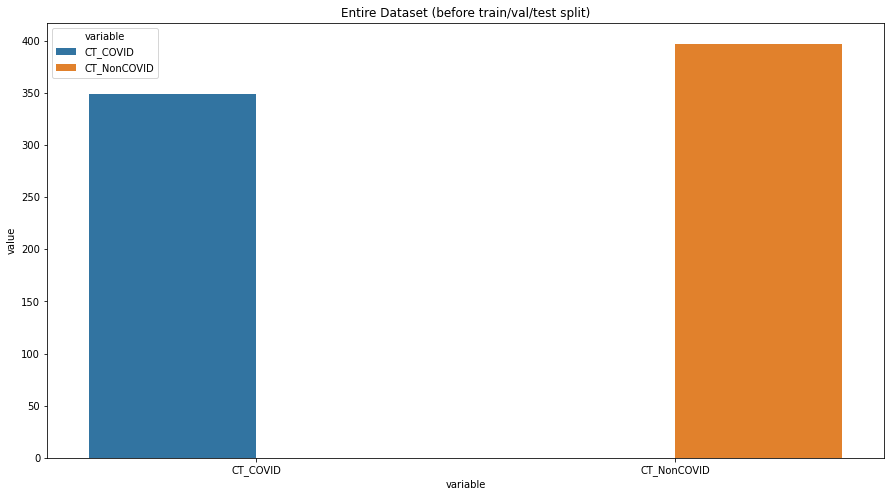

In [32]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}    
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = 
pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value",
hue="variable", **kwargs).set_title(plot_title)
plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(covid_dataset),
plot_title="Entire Dataset (before train/val/test split)")

In [33]:
dummy,test = train_test_split(covid_dataset,test_size=0.25,random_state=42)

In [34]:
train,val = train_test_split(dummy,test_size=0.2,random_state=42)

In [35]:
train_loader = DataLoader(dataset=train, shuffle=True, batch_size=8)
val_loader = DataLoader(dataset=val, shuffle=True, batch_size=1)
test_loader = DataLoader(dataset=test, shuffle=True, batch_size=1)

In [36]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    if dataloader_obj.batch_size == 1:
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else:
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
                
    return count_dict

Text(0.5, 1.0, 'Val Set')

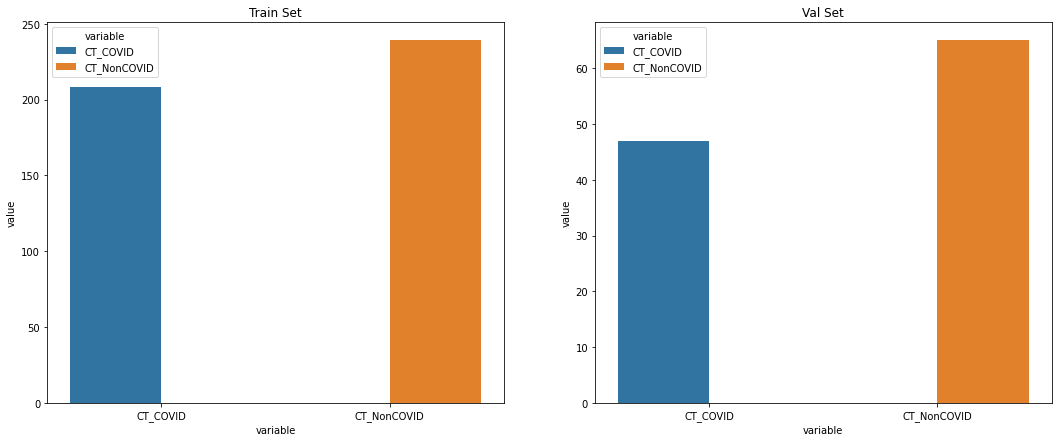

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

plot_from_dict(get_class_distribution_loaders(train_loader, 
covid_dataset), plot_title="Train Set", ax=axes[0])

plot_from_dict(get_class_distribution_loaders(val_loader, 
covid_dataset), plot_title="Val Set", ax=axes[1])

In [38]:
single_batch = next(iter(train_loader))
single_batch[0].shape

torch.Size([8, 1, 224, 224])

In [39]:
single_batch[1]

tensor([1, 0, 0, 1, 1, 1, 1, 0])

In [40]:
single_image = single_batch[0][0]

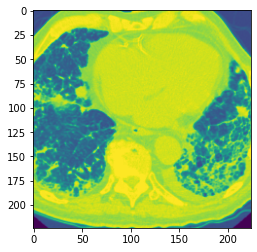

In [41]:
single_image = single_image.permute(1,2,0)
plt.imshow(single_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


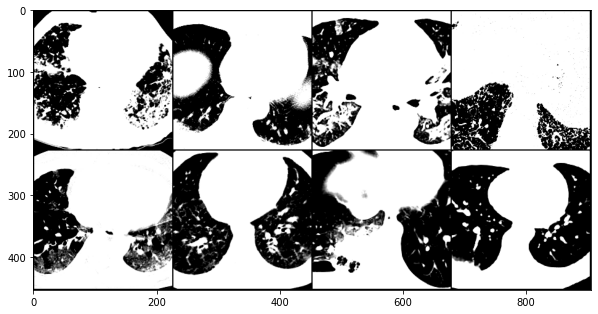

In [42]:
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)

plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))

In [43]:
class CRNet(nn.Module):
    def __init__(self):
        super(CRNet, self).__init__()
        self.block1 = self.conv_block2(c_in=1, c_out=32, kernel_size=7, stride=1)
        self.block2 = self.conv_block(c_in=32, c_out=64, kernel_size=7, stride=1)
        self.block3 = self.conv_block(c_in=64, c_out=128, kernel_size=7, stride=1)
        self.block4 = self.conv_block(c_in=128, c_out=128, kernel_size=10)
        self.block5 = self.conv_block(c_in=128, c_out=2, kernel_size=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.gavgpool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        
        x = self.block2(x)
        x = self.maxpool(x)
        
        x = self.block3(x)
        x = self.maxpool(x)
        
        x = self.gavgpool(x)
        
        x = self.block4(x)
        x = self.block5(x)
        x = F.log_softmax(x, dim=1)
        
        return x
        
    def conv_block2(self, c_in, c_out, **kwargs):
        seq_block = nn.Sequential(nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
        nn.BatchNorm2d(num_features=c_out),nn.ReLU())
        
        return seq_block
    
    def conv_block(self, c_in, c_out, **kwargs):
        seq_block2 = nn.Sequential(nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs), nn.ReLU())
        
        return seq_block2
    
net = CRNet()
print(net)
        

CRNet(
  (block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
  )
  (block4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU()
  )
  (block5): Sequential(
    (0): Conv2d(128, 2, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gavgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)


In [44]:
model = net
model.to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000002)

CRNet(
  (block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
  )
  (block4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU()
  )
  (block5): Sequential(
    (0): Conv2d(128, 2, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gavgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)


In [45]:
dummy2 = model(single_batch[0])
dummy2.shape

torch.Size([8, 2, 1, 1])

In [46]:
def binary_acc(y_pred, y_test):
    y_pred_tag = F.log_softmax(y_pred, dim = 1) 
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [47]:
accuracy_stats = {
    'train': [],
    'val': []
}
loss_stats = {
    'train': [],
    'val': []
}

In [52]:
#TRAINING
print("Begin training.")

for e in tqdm(range(1, 20)): 
    train_epoch_loss = 0
    train_epoch_acc = 0   
    
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad() 
        
        y_train_pred = model(X_train_batch).squeeze() 
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch) 
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
#VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
        
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Begin training.


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 01: | Train Loss: 0.31503 | Val Loss: 0.68428 | Train Acc: 87.625| Val Acc: 66.964
Epoch 02: | Train Loss: 0.31108 | Val Loss: 0.63860 | Train Acc: 88.500| Val Acc: 67.857
Epoch 03: | Train Loss: 0.28699 | Val Loss: 0.82549 | Train Acc: 90.107| Val Acc: 62.500
Epoch 04: | Train Loss: 0.27414 | Val Loss: 0.64407 | Train Acc: 91.411| Val Acc: 72.321
Epoch 05: | Train Loss: 0.25382 | Val Loss: 0.66923 | Train Acc: 91.446| Val Acc: 69.643
Epoch 06: | Train Loss: 0.24959 | Val Loss: 0.66137 | Train Acc: 91.643| Val Acc: 68.750
Epoch 07: | Train Loss: 0.22913 | Val Loss: 0.66438 | Train Acc: 92.393| Val Acc: 68.750
Epoch 08: | Train Loss: 0.21258 | Val Loss: 0.65022 | Train Acc: 92.554| Val Acc: 69.643
Epoch 09: | Train Loss: 0.20681 | Val Loss: 0.66752 | Train Acc: 94.089| Val Acc: 70.536
Epoch 10: | Train Loss: 0.20498 | Val Loss: 0.66543 | Train Acc: 94.054| Val Acc: 69.643
Epoch 11: | Train Loss: 0.18611 | Val Loss: 0.94459 | Train Acc: 94.804| Val Acc: 59.821
Epoch 12: | Train Los

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

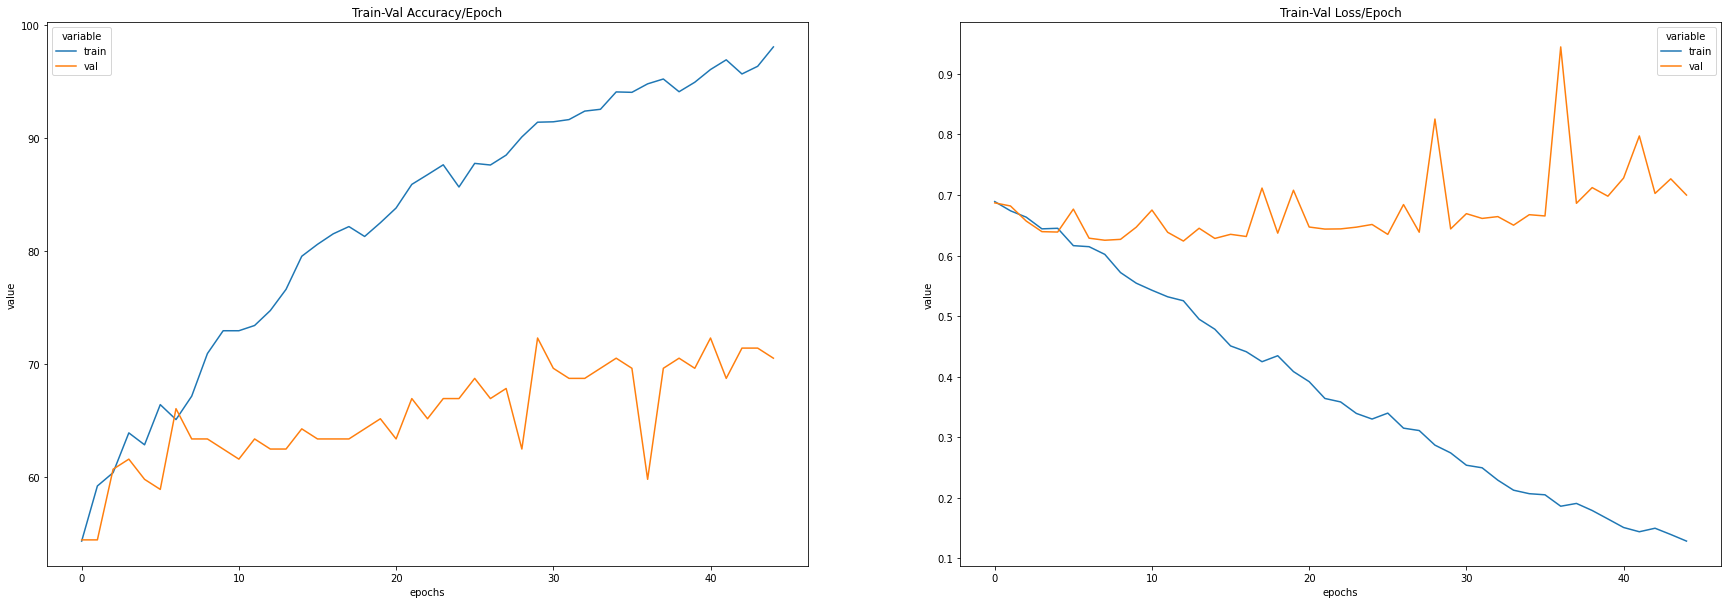

In [53]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  
ax=axes[0]).set_title('Train-Val Accuracy/Epoch')

sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", 
ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [54]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)        
        
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

  0%|          | 0/187 [00:00<?, ?it/s]

In [55]:
y_pred_list = [i[0][0][0] for i in y_pred_list]

y_true_list = [i[0] for i in y_true_list]

In [56]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80        94
           1       0.79      0.82      0.80        93

    accuracy                           0.80       187
   macro avg       0.80      0.80      0.80       187
weighted avg       0.80      0.80      0.80       187

